# Above Ground Biomass Estimation Using PROSAIL method - Physical based model
Author: Rahul Shah

In [3]:
import pyprosail
help(pyprosail.run)

Help on function run in module pyprosail:

run(n: 'float', cab: 'float', car: 'float', cbrown: 'float', cw: 'float', cm: 'float', psoil: 'float', lai: 'float', hspot: 'float', tts: 'float', tto: 'float', psi: 'float', typelidf: 'int', lidfa: 'int | float', lidfb: 'int | float') -> 'np.ndarray'
    Runs the ProSAIL model with the given parameters and returns a wavelength-reflectance
    array.
    
    Arguments:
      
      * ``n`` -- Structure co-efficient
      * ``cab`` -- Chlorophyll content (ug per cm^2)
      * ``car`` -- Carotenoid content (ug per cm^2)
      * ``cbrown`` -- Brown pigment content (arbitrary units)
      * ``cw`` -- Equivalent Water Thickness (cm)
      * ``cm`` -- Leaf Mass per unit area (g per cm^2)
      * ``psoil`` -- Soil reflectance: wet soil = 0, dry soil = 1
      * ``lai`` -- Leaf Area Index
      * ``hot_spot`` -- Hot spot parameter
      * ``tts`` -- Solar zenith angle (degrees)
      * ``tto`` -- Observer zenith angle (degrees)
      * ``psi`` -- rel

In [52]:
import rasterio
import numpy as np
import os
import xml.etree.ElementTree as ET

file_path = '/satellite/planetscope_8-band/'

# List date directories and sort them
date_dir = sorted([d for d in os.listdir(file_path) if os.path.isdir(os.path.join(file_path, d))])

for date in date_dir[0:1]:
    print(date)
    if 'manifest' in date:
        continue
    date_path = os.path.join(file_path, date)
    print(date_path)
    file_list = os.listdir(date_path)
    #print("file list:", file_list)
    for file in file_list:
        if 'SR' in file:
            tiff_file = file
        if 'udm2' in file:
            udm_file = file
        if 'metadata_clip.xml' in file:
            mtd_file = file
    image_path = os.path.join(date_path, tiff_file)
    udm_path =  os.path.join(date_path, udm_file)
    mtd_path = os.path.join(date_path, mtd_file)
    print(image_path)
    print(udm_path)
    print(mtd_path)
    
    # Read and parse the XML file
    tree = ET.parse(mtd_path)
    root = tree.getroot()

    # Define the namespaces
    namespaces = {
        'ps': 'http://schemas.planet.com/ps/v1/planet_product_metadata_geocorrected_level',
        'eop': 'http://earth.esa.int/eop',
        'gml': 'http://www.opengis.net/gml',
        'opt': 'http://earth.esa.int/opt'
    }

    # Find the 'using' element
    using_elem = root.find('gml:using', namespaces)

    if using_elem is not None:
        # Extract acquisition parameters
        acquisition = using_elem.find('.//ps:Acquisition', namespaces)
        if acquisition is not None:
            print("Angle Information:")

            # Incidence Angle
            incidence_angle = acquisition.find('eop:incidenceAngle', namespaces)

            # Illumination Azimuth Angle
            ill_azimuth_angle = acquisition.find('opt:illuminationAzimuthAngle', namespaces)
            
            # Illumination Elevation Angle
            ill_elevation_angle = acquisition.find('opt:illuminationElevationAngle', namespaces)

            # Azimuth Angle
            azimuth_angle = acquisition.find('ps:azimuthAngle', namespaces)

            # Spacecraft View Angle
            spacecraft_view_angle = acquisition.find('ps:spaceCraftViewAngle', namespaces)
        else:
            print("No acquisition information found in the XML.")
    else:
        print("No 'using' element found in the XML.")
        
    with rasterio.open(image_path) as src:
        ca_band = src.read(1).astype(float) / 10000
        blue_band = src.read(2).astype(float) / 10000
        greeni_band = src.read(3).astype(float) / 10000
        green_band = src.read(4).astype(float) / 10000
        yellow_band = src.read(5).astype(float) / 10000
        red_band = src.read(6).astype(float) / 10000
        rededge_band = src.read(7).astype(float) / 10000
        nir_band = src.read(8).astype(float) / 10000
        
        observed_reflectance = [ca_band, blue_band, greeni_band, green_band, yellow_band, red_band, rededge_band, nir_band]


20200602
/S/satellite/planetscope_8-band/development/136/20200602
/S/satellite/planetscope_8-band/development/136/20200602/20200602_171146_69_2263_3B_AnalyticMS_SR_8b_clip.tif
/S/satellite/planetscope_8-band/development/136/20200602/20200602_171146_69_2263_3B_udm2_clip.tif
/S/satellite/planetscope_8-band/development/136/20200602/20200602_171146_69_2263_3B_AnalyticMS_8b_metadata_clip.xml
Angle Information:
  Incidence Angle: 3.270671e+00 deg
  Illumination Azimuth Angle: 1.255845e+02 deg
  Illumination Elevation Angle: 5.796077e+01 deg
  Azimuth Angle: 1.292307e+01 deg
  Spacecraft View Angle: 2.935778e+00 deg


In [55]:
import pyprosail
import numpy as np

# Define the angles extracted from the metadata
tts = float(incidence_angle.text)  # Solar Zenith Angle
tto = float(spacecraft_view_angle.text)  # Observer Zenith Angle
psi = (float(ill_azimuth_angle.text) - float(azimuth_angle.text)) % 360  # Relative Azimuth Angle

# Define the PROSAIL parameters (use a range for LUT)
LAI_values = np.linspace(0, 5, 50)  # Leaf Area Index range
DMC_values = np.linspace(0.001, 0.02, 50)  # Dry Matter Content range
soil_reflectance = 0.1  # Soil reflectance, adjust as needed

# Placeholder for LUT and corresponding parameter values
lut = []
params = []

# Simulate reflectance for each combination of LAI and DMC
for LAI in LAI_values:
    for DMC in DMC_values:
        # Run PROSAIL with your parameters
        spectral_reflectance = pyprosail.run(
            n=1.5,  # Example structure coefficient, adjust as needed
            cab=40,  # Chlorophyll content, adjust as needed
            car=10,  # Carotenoid content, adjust as needed
            cbrown=0.1,  # Brown pigment content, adjust as needed
            cw=0.015,  # Equivalent water thickness, adjust as needed
            cm=DMC,  # Dry matter content
            lai=LAI,  # Leaf Area Index
            hspot=0.1,  # Hotspot effect parameter, adjust as needed
            tts=tts,  # Solar zenith angle
            tto=tto,  # Observer zenith angle
            psi=psi,  # Relative azimuth angle
            psoil=soil_reflectance,  # Soil reflectance
            typelidf=1,  # Leaf distribution function type
            lidfa=0.5,  # Leaf distribution parameter A
            lidfb=-0.15  # Leaf distribution parameter B
        )

        # Append the simulated reflectance and corresponding parameters to LUT
        lut.append(spectral_reflectance)
        params.append((LAI, DMC))

# Convert LUT and params to numpy arrays
lut = np.array(lut)
params = np.array(params)


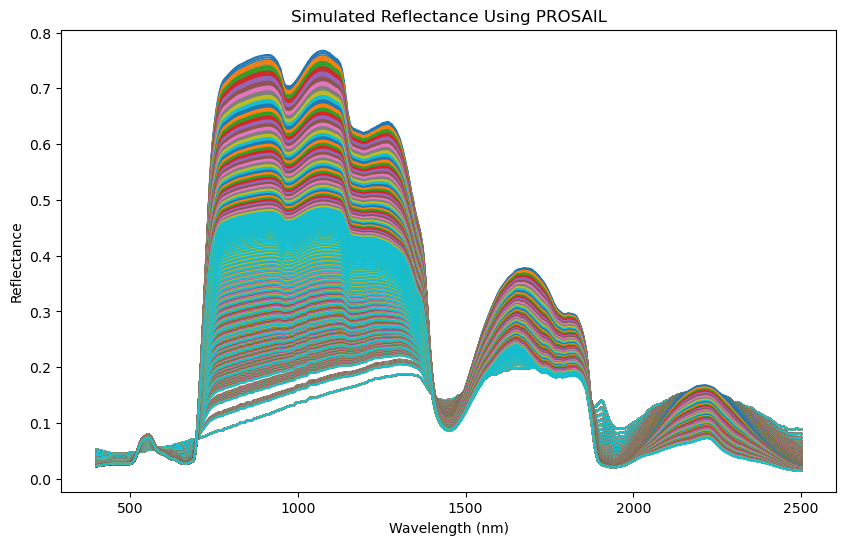

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming lut has shape (2500, 2101, 2)
# Extract the reflectance values from the last dimension
reflectance_values = lut[:, :, 1]  # Extract the second value which is reflectance

# Wavelengths from 400 to 2500 nm
wavelengths = np.arange(400, 2501)

# Create the plot
plt.figure(figsize=(10, 6))

# Loop through the spectra and plot each one
for i in range(2500):  # Iterate over the 2500 spectra
    plt.plot(wavelengths, reflectance_values[i], label=f"Sim {i+1}")

# Label the axes and add a title
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("Simulated Reflectance Using PROSAIL")

# Show the plot
plt.show()



In [68]:
import numpy as np
import rasterio
from scipy.interpolate import interp1d

# Function to calculate RMSE between observed and simulated reflectance
def rmse(observed, simulated):
    return np.sqrt(((observed - simulated) ** 2).mean())

# Function to interpolate LUT reflectances to PlanetScope bands
def interpolate_lut(lut, planet_bands_centers):
    wavelengths = lut[:, 0]  # Wavelengths from LUT
    reflectances = lut[:, 1]  # Reflectances from LUT
    interp_reflectances = np.interp(planet_bands_centers, wavelengths, reflectances)
    return interp_reflectances

# PlanetScope band centers (you can adjust based on your bands)
planet_bands_centers = [441.5, 490, 531, 565, 610, 665, 705, 865]

# Initialize the raster dimensions (assuming you have the same size for all bands)
nrows, ncols = ca_band.shape

# Empty arrays to store the LAI, DMC, and biomass for each pixel
lai_raster = np.zeros((nrows, ncols))
dmc_raster = np.zeros((nrows, ncols))
agb_raster = np.zeros((nrows, ncols))

# Iterate through each pixel
for row in range(nrows):
    for col in range(ncols):
        # Extract observed reflectance for the pixel
        observed_reflectance = [
            ca_band[row, col],
            blue_band[row, col],
            greeni_band[row, col],
            green_band[row, col],
            yellow_band[row, col],
            red_band[row, col],
            rededge_band[row, col],
            nir_band[row, col]
        ]
        
        # Skip pixels with no valid data
        if np.isnan(observed_reflectance).any():
            continue
        
        # Find the best match in the LUT for this pixel
        best_fit_idx = np.argmin([rmse(observed_reflectance, interpolate_lut(lut_spectrum, planet_bands_centers)) for lut_spectrum in lut])
        
        # Retrieve the best LAI and DMC from the LUT
        best_LAI, best_DMC = params[best_fit_idx]
        
        # Calculate the AGB (Aboveground Biomass)
        agb = best_LAI * best_DMC
        
        # Store LAI, DMC, and AGB in the rasters
        lai_raster[row, col] = best_LAI
        dmc_raster[row, col] = best_DMC
        agb_raster[row, col] = agb

# Save the biomass raster as a GeoTIFF file
with rasterio.open('biomass_raster.tif', 'w', 
                   driver='GTiff', 
                   height=nrows, 
                   width=ncols, 
                   count=1, 
                   dtype=agb_raster.dtype) as dst:
    dst.write(agb_raster, 1)


/opt/conda/envs/ripp_gpu/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [72]:
import numpy as np
import rasterio

# Open the PlanetScope image bands
with rasterio.open(image_path) as src:
    red_band = src.read(6).astype(float) / 10000  # Red band (Band 6)
    nir_band = src.read(8).astype(float) / 10000  # NIR band (Band 8)

# Calculate NDVI
ndvi = (nir_band - red_band) / (nir_band + red_band)

# Avoid division by zero and log of negative numbers
ndvi = np.clip(ndvi, 1e-6, 1.0)

# LAI estimation using a logarithmic relationship
k = 0.5  # Extinction coefficient
lai = -np.log((1 - ndvi) / ndvi) * k

# Save the LAI as a raster file
with rasterio.open('lai_raster.tif', 'w', 
                   driver='GTiff', 
                   height=src.height, 
                   width=src.width, 
                   count=1, 
                   dtype=red_band.dtype) as dst:
    dst.write(lai, 1)


/tmp/ipykernel_14607/3688492169.py:10: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir_band - red_band) / (nir_band + red_band)
